
=== Model performance comparison ===
              Model        R²       MSE       MAE
3    Support Vector  0.572001  0.862473  0.466428
1           XGBoost  0.533095  0.940874  0.567377
0     Random Forest  0.512016  0.983349  0.548856
4    Neural Network  0.463623  1.080867  0.687222
2  Ridge Regression  0.459540  1.089096  0.698365

=== Random Forest feature importance ===
         feature  importance
1  longitude_deg    0.322720
4             ph    0.183138
0   latitude_deg    0.154825
3    elevation_m    0.119794
2        depth_m    0.089541
5    env_feature    0.005416


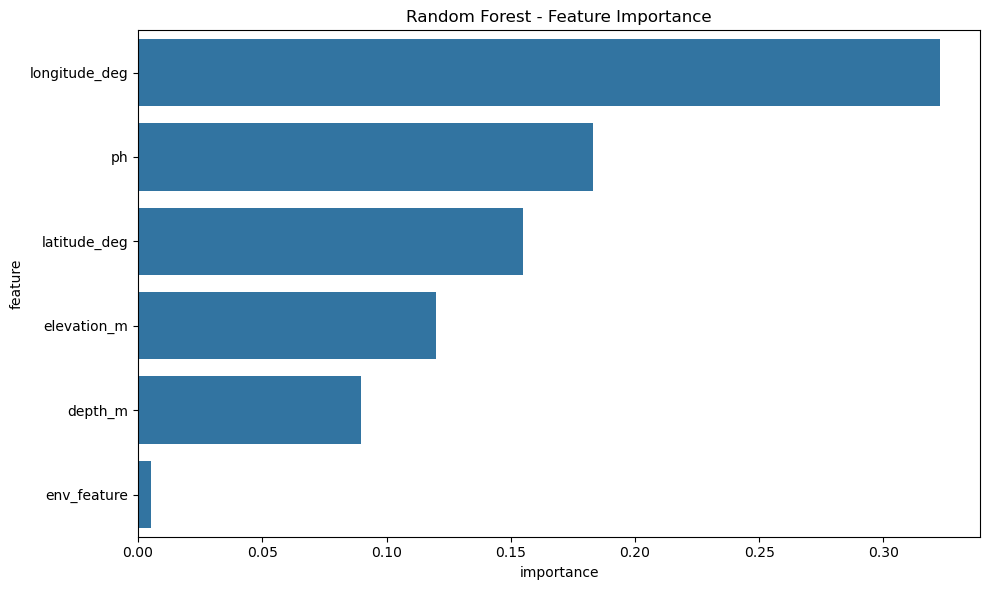


=== XGBoost feature importance ===
         feature  importance
1  longitude_deg    0.134502
3    elevation_m    0.079294
2        depth_m    0.058947
5    env_feature    0.028645
4             ph    0.023010
0   latitude_deg    0.016764


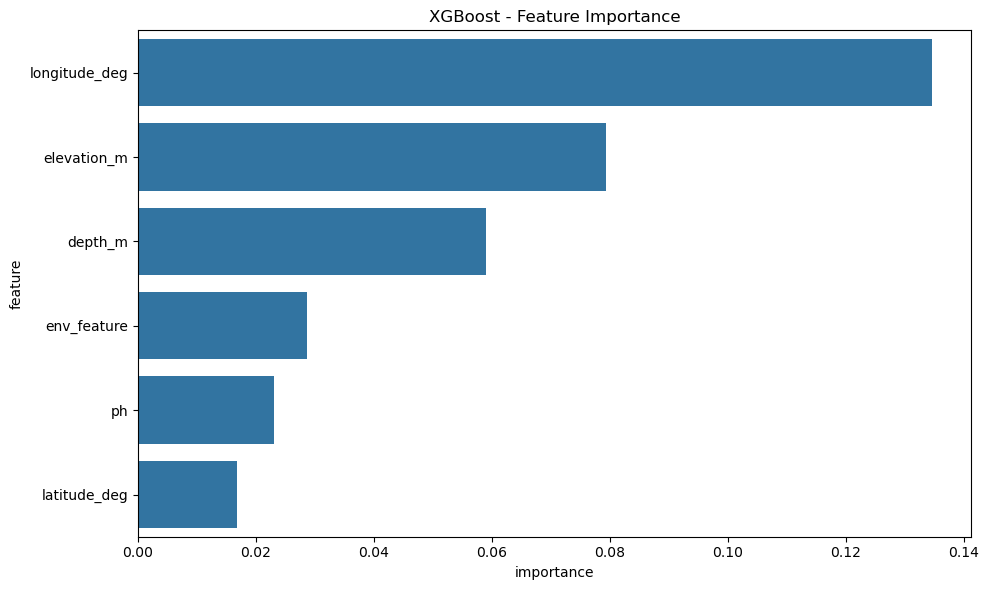


=== Ridge Regression feature importance ===
         feature  importance
5    env_feature    0.607954
0   latitude_deg    0.163307
2        depth_m    0.100384
3    elevation_m    0.095901
4             ph    0.034869
1  longitude_deg    0.023970


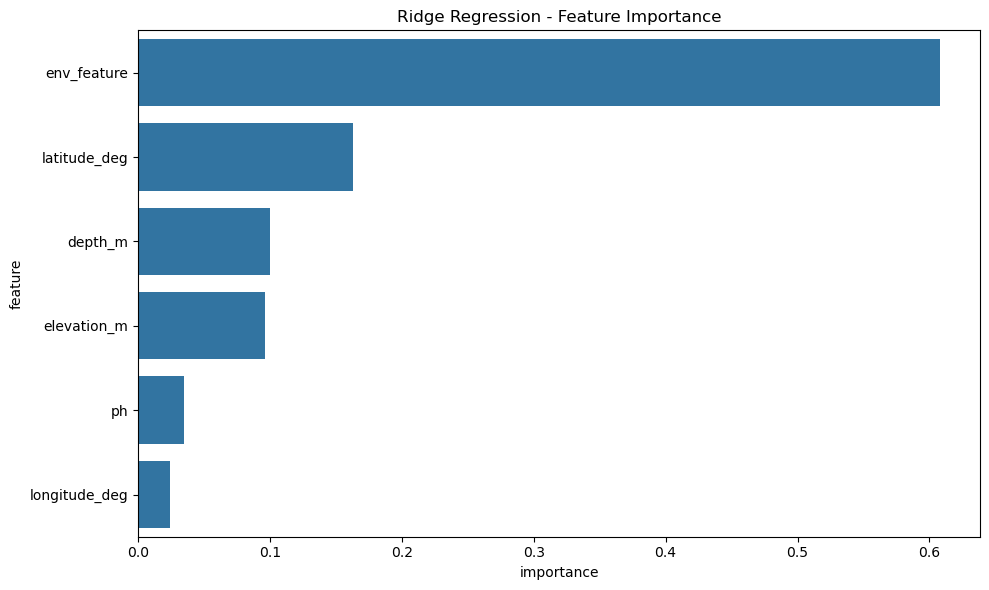


=== Support Vector feature importance ===
         feature  importance
2        depth_m    0.283457
1  longitude_deg    0.242415
3    elevation_m    0.211507
0   latitude_deg    0.181976
4             ph    0.146375
5    env_feature    0.023643


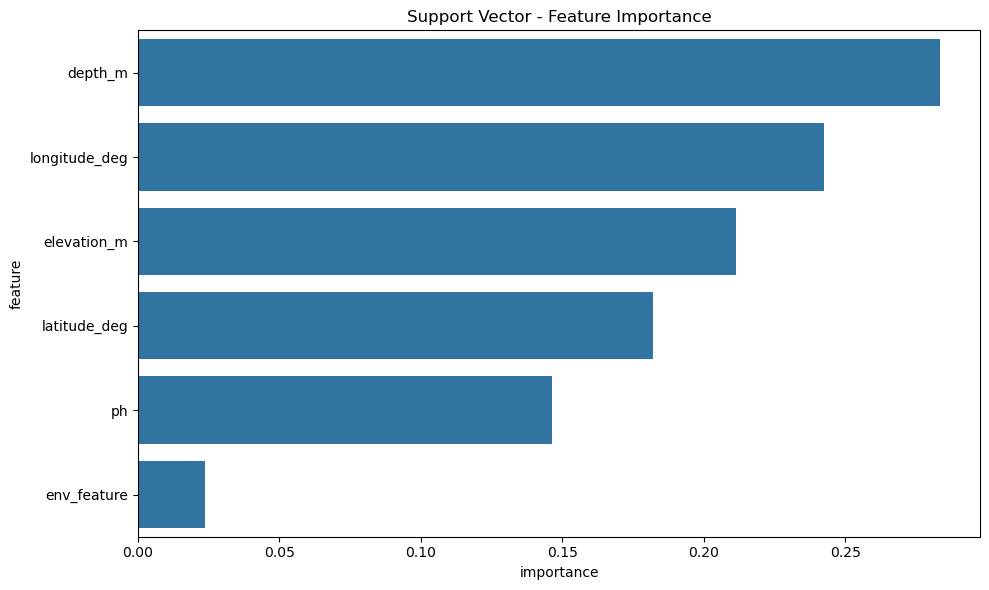


=== Neural Network feature importance ===
         feature  importance
1  longitude_deg    0.401253
4             ph    0.164155
5    env_feature    0.157705
2        depth_m    0.115238
3    elevation_m    0.114817
0   latitude_deg    0.111999


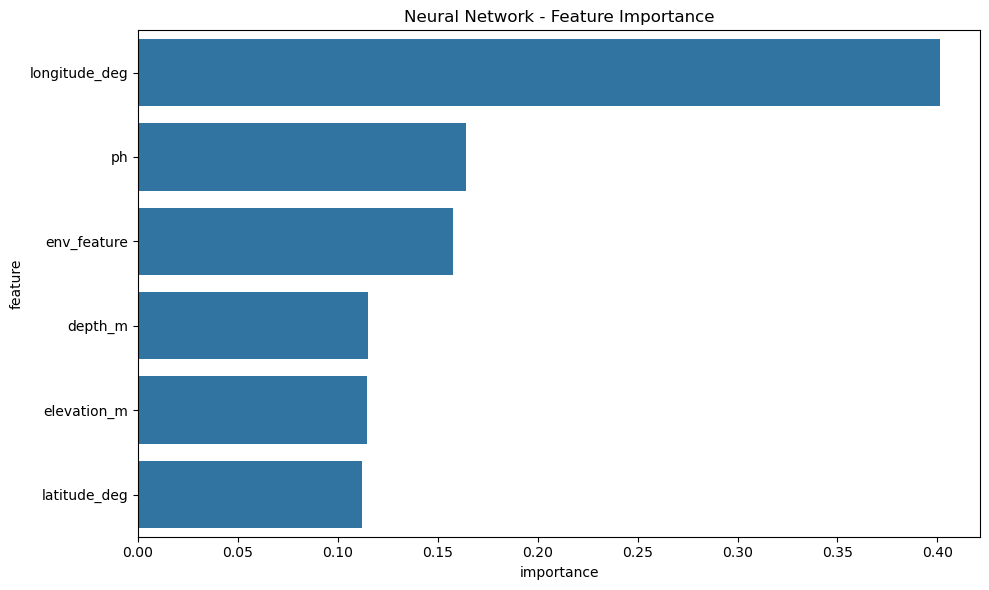


=== Internal Importance of Environmental Characteristics ===
                            env_type  importance
22                          vineyard    0.168262
9   extreme high temperature habitat    0.114977
11                       forest soil    0.096951
6                 cultivated habitat    0.060632
1                  agricultural soil    0.048213
23                           volcano    0.024265
3                                bog    0.016809
13                          mountain    0.015895
17                        permafrost    0.012597
12                    grassland soil    0.011357
19                         shrubland    0.006303
5           cold temperature habitat    0.004233
8                           dry soil    0.003506
14             oil contaminated soil    0.003042
10                            forest    0.001567
20                             taiga    0.000994
7                           dry lake    0.000783
15                           pasture    0.000490
2      

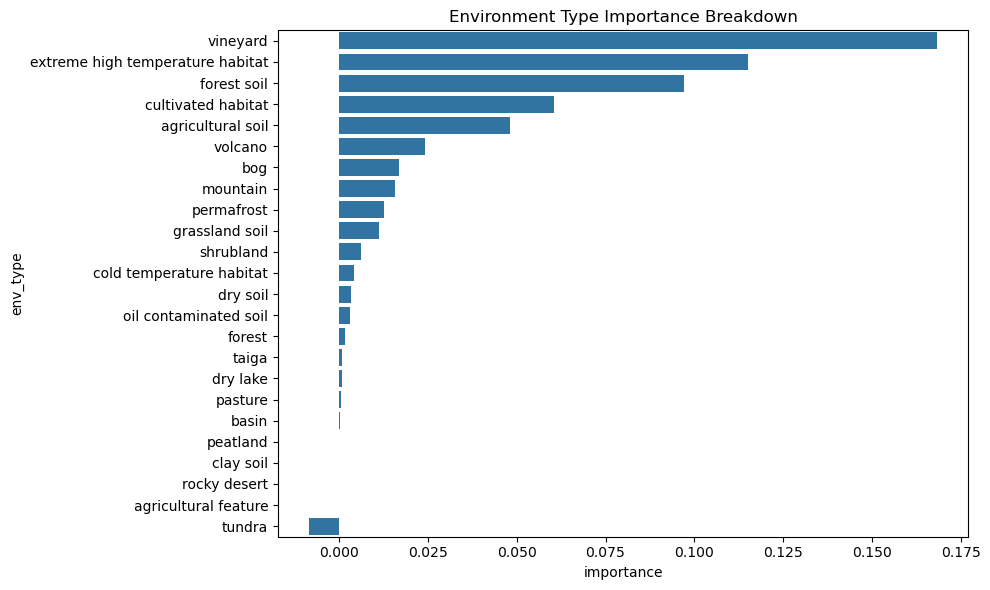


=== SHAP Analysis (Best Model) (Support Vector) ===


  0%|          | 0/612 [00:00<?, ?it/s]

In [ ]:
# ================ code ================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import shap
from scipy import stats
from itertools import combinations
from sklearn.inspection import permutation_importance
from scipy.sparse import issparse

# 1. data preperation
df = pd.read_excel('raw_data_9.xlsx')
features = ['latitude_deg', 'longitude_deg', 'depth_m', 'elevation_m', 'env_feature', 'ph']
target = 'adiv_shannon'

X = df[features]
y = df[target]

# 2. data partitioning
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Preprocessing pipeline
numeric_features = ['latitude_deg', 'longitude_deg', 'depth_m', 'elevation_m', 'ph']
categorical_features = ['env_feature']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# 4. Model Definition
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "Ridge Regression": Ridge(alpha=1.0),
    "Support Vector": SVR(kernel='rbf', C=100, gamma=0.1),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
}

# 5. Model Training and Evaluation
results = []
all_predictions = {}

for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    all_predictions[name] = y_pred
    
    results.append({
        'Model': name,
        'R²': r2_score(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'Pipeline': pipe
    })

results_df = pd.DataFrame(results).sort_values('R²', ascending=False)
print("\n=== Model performance comparison ===")
print(results_df[['Model', 'R²', 'MSE', 'MAE']])

# 6. Feature Importance Analysis
def get_grouped_importance(importance, feature_names):
    """Merge one hot encoded classification features into original features"""
    grouped = {
        'latitude_deg': 0,
        'longitude_deg': 0,
        'depth_m': 0,
        'elevation_m': 0,
        'ph': 0,
        'env_feature': 0  # Merge all environment types
    }
    
    for i, name in enumerate(feature_names):
        if name in grouped:
            grouped[name] = importance[i]
        elif name.startswith('env_feature_'):
            grouped['env_feature'] += importance[i]
    
    env_count = sum(1 for name in feature_names if name.startswith('env_feature_'))
    if env_count > 0:
        grouped['env_feature'] = grouped['env_feature'] / env_count
    
    return pd.DataFrame({
        'feature': list(grouped.keys()),
        'importance': list(grouped.values())
    }).sort_values('importance', ascending=False)

# Obtain feature names
preprocessor.fit(X_train)
numeric_cols = numeric_features
categorical_cols = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(['env_feature'])
all_cols = np.concatenate([numeric_cols, categorical_cols])

# Feature importance calculation (compatible with sparse matrices)
for result in results:
    model = result['Pipeline'].named_steps['regressor']
    print(f"\n=== {result['Model']} feature importance ===")
    
    try:
        X_test_processed = result['Pipeline'].named_steps['preprocessor'].transform(X_test)
        
        # Processing Sparse Matrix
        if issparse(X_test_processed):
            X_test_processed = X_test_processed.toarray()
        
        if hasattr(model, 'feature_importances_'):  # tree model
            importance = model.feature_importances_
        elif hasattr(model, 'coef_'):  # linear
            importance = np.abs(model.coef_.flatten())
        elif isinstance(model, (SVR, MLPRegressor)):  # SVM/neural network
            # Use more stable permutation importance
            perm_result = permutation_importance(
                model, X_test_processed, y_test, 
                n_repeats=10, 
                random_state=42
            )
            importance = perm_result.importances_mean
        else:
            raise ValueError("Unsupported model type")
        
        # Obtain the importance of grouping
        grouped_importance = get_grouped_importance(importance, all_cols)
        print(grouped_importance)
        
        # visulization
        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=grouped_importance)
        plt.title(f"{result['Model']} - Feature Importance")
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Feature importance calculation failed: {str(e)}")

# 7. Detailed internal analysis of environmental characteristics (optional)
print("\n=== Internal Importance of Environmental Characteristics ===")
env_idx = [i for i, name in enumerate(all_cols) if name.startswith('env_feature_')]
if env_idx:
    # Use the best model for analysis
    best_model = max(results, key=lambda x: x['R²'])
    model = best_model['Pipeline'].named_steps['regressor']
    
    try:
        X_test_processed = best_model['Pipeline'].named_steps['preprocessor'].transform(X_test)
        if issparse(X_test_processed):
            X_test_processed = X_test_processed.toarray()
        
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importance = np.abs(model.coef_.flatten())
        else:
            perm_result = permutation_importance(model, X_test_processed, y_test, n_repeats=10)
            importance = perm_result.importances_mean
        
        env_importance = pd.DataFrame({
            'env_type': [all_cols[i].replace('env_feature_', '') for i in env_idx],
            'importance': importance[env_idx]
        }).sort_values('importance', ascending=False)
        
        print(env_importance)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='env_type', data=env_importance)
        plt.title("Environment Type Importance Breakdown")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Environmental feature analysis failed: {str(e)}")

# 8. SHAP Analysis (Best Model)
best_model = max(results, key=lambda x: x['R²'])
print(f"\n=== SHAP Analysis (Best Model) ({best_model['Model']}) ===")

try:
    # prepare
    X_train_processed = best_model['Pipeline'].named_steps['preprocessor'].transform(X_train)
    if issparse(X_train_processed):
        X_train_processed = X_train_processed.toarray()
    
    # selection
    if isinstance(best_model['Pipeline'].named_steps['regressor'], (RandomForestRegressor, XGBRegressor)):
        explainer = shap.TreeExplainer(best_model['Pipeline'].named_steps['regressor'])
    else:
        explainer = shap.KernelExplainer(
            best_model['Pipeline'].named_steps['regressor'].predict, 
            shap.sample(X_train_processed, 100)
        )
    
    # calculation
    shap_values = explainer.shap_values(X_train_processed)
    
    # visualization
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_train_processed, feature_names=all_cols, plot_type="bar")
    plt.title("SHAP Feature Importance")
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"SHAP analysis failed: {str(e)}")


In [ ]:
    best_model_name = results_df.iloc[0]['Model']
best_pipeline = results_df.iloc[0]['Pipeline']
y_pred = best_pipeline.predict(X_test)
residuals = y_test - y_pred

# plt residual
plt.figure(figsize=(12, 5))

# residual
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, bins=30, color='skyblue')
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.title(f"{best_model_name} - residual distribution\n(Mean: {residuals.mean():.2f})", pad=10)
plt.xlabel("residual")

# residual - pre
plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals, alpha=0.6, color='orange', edgecolor='white')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title(f"{best_model_name} - relationship between residual and prediction", pad=10)
plt.xlabel("prediction")
plt.ylabel("residual")

plt.tight_layout()
plt.show()


In [ ]:
import time
if 'train_times' not in locals():
    train_times = {}
    for name, model in models.items():
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])
        start_time = time.time()
        pipe.fit(X_train, y_train)
        train_times[name] = time.time() - start_time

# train time bar
plt.figure(figsize=(10, 5))
sns.barplot(
    x=list(train_times.keys()),
    y=list(train_times.values()),
    palette="Blues_d"
)
plt.title("train time", pad=15)
plt.xlabel("model")
plt.ylabel("train time (sec)")
plt.xticks(rotation=45)
for i, v in enumerate(train_times.values()):
    plt.text(i, v+0.1, f"{v:.4f}s", ha='center')
plt.show()

In [ ]:
print(train_times)